In [1]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(2*11.7,2*8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
from itertools import product
import string
from scipy.ndimage.filters import gaussian_filter, median_filter

In [39]:
class River:
    def __init__(self):
        self.error = 0
        probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0]], columns=['initial eDNA', 'probability of amplification'])
        probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
        model2 = sm.Logit(probfunction['probability of amplification'].values, probfunction['copy number'].values)
        self.result2 = model2.fit( disp=0)
        self.PofCaptureNet = 0.01

    def change_er(self,er):
        self.error = er    
        
    def init_river_params(self, V,D,u,λ, H):
        self.V = V
        self.u = u
        self.λ = λ
        self.D = D
        self.H = H
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf, self.sup = self.Find_detection_range(0.001)
    def init_sampling_strategy(self, pf, boat_V, time):
        self.pf = pf
        self.BV = boat_V
        self.T = time
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf, self.sup = self.Find_detection_range(0.001) #0.005
        
    def init_fish(self, dist_bet_fish, biomass):
        self.B = biomass
        self.dist = dist_bet_fish
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf, self.sup = self.Find_detection_range(0.001) #0.005
        
    def CtoP(self,c):
        return (self.result2.predict(c)-.5)/.5
        #return (1/(1+np.exp(-(-.83+ .00781*c)))).reshape(-1,1)

        
    def CeDNA_1_Source(self,x):
        constants = (self.B*self.u)/(sqrt(self.V**2 + 4*self.D*self.λ)*self.H)
        if x < 0: 
            result = constants * exp**(  (self.V+ sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        else: 
            result = constants * exp**(  (self.V- sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        if result < 1: return 0
        return result
    
    def fish_locations_transect(self):
        x = 0
        returnable = []
        while x > self.inf :
            a = -np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        returnable = returnable[::-1]
        x = 0        
        while x <  self.BV*self.T + self.sup:
            a = np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        return returnable

    def _fish_locations_net(self):
        ret = []
        x = 0
        while x< self.BV*self.T:
            x += np.random.exponential(self.dist, 1)[0]
            ret += [x]
        return ret[:-1]
            
    def average_catch(self, n = 1000):
        lis = np.array([sum([1 if random.random()< self.PofCaptureNet else 0 for x in self._fish_locations_net()]) for x in range(n)])
        return {'mean': lis.mean(), 'std': lis.std(), 'Prob_of_detection': 1 - (np.count_nonzero(lis)/len(lis)), 'list': lis}
    
    #@staticmethod
    def _solved_river_abv(self,x):
        return  -(self.pf/(self.BV*self.H)) *(2*self.B*self.u*self.D) /( 4*self.D*self.λ - self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2)* exp**( (self.V - sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _solved_river_bl(self,x):
        return  (self.pf/(self.BV*self.H)) *(2*self.B*self.u*self.D) /(4*self.D*self.λ + self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2) * exp**( (self.V + sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _sld_intermediary(self,Xi, Xf):
        low, high = sorted([Xi, Xf])
        if low >= 0:
            return abs(self._solved_river_abv(Xf) - self._solved_river_abv(Xi))
        if high <= 0: 
            return abs(self._solved_river_bl(Xf) - self._solved_river_bl(Xi))

        return self._sld_intermediary(low, 0) + self._sld_intermediary(0, high)
    
    def sample_eDNA_transect(self,x0):
        ret = self._sld_intermediary(x0, x0 + self.BV*self.T)  + random.gauss(0, self.error)
        if ret< 0: return 0
        else: return ret
    
    def sample_eDNA_transect_n_sources(self):
        return np.array([self.sample_eDNA_transect( -dis )*(1+random.gauss(0, self.error))  for dis in self.fish_locations_transect()]).sum()
    
    
    def Sample_Multiple_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
    
        for i in distlist:
            self.dist = i
            response += [self.sample_eDNA_transect_n_sources()]
        
        self.dist = store_dist
        response = self.CtoP(response)
        return {'distances': distlist, 'response': response, 'avg': np.array(response).mean(), 'std': np.array(response).std()}
    
    
    def Catch_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]

        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
        
        for i in distlist:
            self.dist = i
            response += [self.average_catch(n=1)['mean']]
        
        self.dist = store_dist
        response = np.array(response)
        det_dist = np.array([1 if x> 0 else 0 for x in response])
        
        return {'distances': distlist, 'catch': response, 'detection': det_dist,'avg': response.mean(), 'std': response.std(), 'avg_detection': det_dist.mean(), 'std_detection': det_dist.std()}

    def Find_detection_range(self, p):
        max_up = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, 0, 1e10)
        max_down = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, -1e10, 0)
        return sorted([max_down, max_up])
    def print_params(self):
        print(' '.join([i+'='+str(self.__dict__[i]) for i in list(self.__dict__.keys())[3:-2]]))

    

# Set parameter values

In [16]:
layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='70%')
style = {'description_width': 'initial'}

@interact(
         biomass_per_fish_cluster = widgets.BoundedFloatText(value=1, min=0.01, max=10, step=0.01,   layout = layout, style = style),
         river_velocity = widgets.BoundedFloatText(value=0.00, min=0.0000, max=1, step=0.1,      layout = layout, style = style),
         diffusion = widgets.BoundedFloatText(value=0.1, min=1e-4, max=1e2, step=1e-4,   layout = layout, style = style),
         degradation = widgets.BoundedFloatText(value=0.1317/3600 , min=1e-5, max=1e-2, step=1e-4,   readout=True,  layout = layout, style = style), #0.000733
         eDNA_production_rate = widgets.BoundedFloatText(value=30937.5, min=1e6/60, max=1e8/60, step=1e6/60, layout = layout, style = style),
         transect_length = widgets.BoundedFloatText(value=1e-5, min=1e-5, max=1000, step=1,orientation='horizontal', layout = layout, style = style),
         sample_volume = widgets.BoundedFloatText(value=1, min=0.05, max=10, step=0.05, layout = layout, style = style),
         river_cross_section = widgets.BoundedFloatText(value=10, min=.1, max=100, step=0.01,  layout = layout, style = style),
)
def Optimize(biomass_per_fish_cluster, river_velocity, diffusion, degradation,eDNA_production_rate, transect_length, sample_volume, river_cross_section):

    global fish_params 
    fish_params = { 'dist_bet_fish':5, 'biomass': biomass_per_fish_cluster}
    global river_params 
    river_params = {'V': river_velocity, 'D': diffusion, 'λ': degradation, 'u':eDNA_production_rate, 'H':river_cross_section}
    global sampling_params
    sampling_params = {'boat_V': transect_length/600, 'time': 600, 'pf':sample_volume/600}
    print(fish_params)
    print(river_params)
    print(sampling_params)
    


interactive(children=(BoundedFloatText(value=1.0, description='biomass_per_fish_cluster', layout=Layout(align_…

# eDNA distribution

In [5]:
@interact_manual(
         max_upstream = widgets.BoundedFloatText(value=-1000, max=0, min=-10000, step=0.01,   layout = layout, style = style),
         max_downstream = widgets.BoundedFloatText(value=1000, min=0, max=10000, step=0.1,      layout = layout, style = style),
         new_velocity = widgets.BoundedFloatText(value=0.3,  min = 0, max = 10,  step=.1,  layout = layout, style = style),
         new_transect = widgets.BoundedFloatText(value=500,  min = 0, max = 1000, step=100,  layout = layout, style = style),
)
def compare_diff_velocities_and_transects(max_upstream, max_downstream,new_velocity, new_transect):
    distlist = [random.random()*100 for i in range(1000)]
    river = River()
    river.init_fish(**fish_params)
    river.init_river_params(**river_params)
    river.init_sampling_strategy(**sampling_params)
    river.error = 1e-1

    ranges = np.linspace(max_upstream - new_transect ,max_downstream + new_transect ,10000)


    river.BV = new_transect/river.T
    transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
    plt.plot(ranges+ river.BV*river.T/2, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
    plt.fill_between(ranges+ river.BV*river.T/2,transect , 0, 
                     color = 'lightblue', alpha = .6) 


    river.BV = 1e-6
    discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

    plt.plot(ranges+ river.BV*river.T/2, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
    plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
    sns.despine()
    plt.ylim([0,1.1])

    plt.legend(fontsize = 30, loc = 'upper left')#, title = 'Sampling mode'


    plt.xlabel("distance from source",fontsize = 25)
    plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
    plt.title('Comparison between Discrete and Transect sampling DNA yield - No Flow')


    plt.fill_between(ranges, discrete , 0, 
                     color = 'red', alpha = .3) 

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlim([max_upstream,max_downstream])
    plt.legend()
    plt.show()


    river.V = new_velocity

    river.BV = new_transect/river.T
    transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
    plt.plot(ranges + river.BV*river.T/2, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
    plt.fill_between(ranges+ river.BV*river.T/2,transect , 0, 
                     color = 'lightblue', alpha = .6) 




    river.BV = 1e-5
    discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

    plt.plot(ranges+ river.BV*river.T/2, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
    plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
    sns.despine()
    plt.ylim([0,1])

    plt.legend(fontsize = 30, loc = 'upper left')


    plt.xlabel("distance from source",fontsize = 25)
    plt.ylabel("Probability of detection",fontsize = 25) 
    plt.title('Comparison between Discrete and Transect sampling DNA yield - High Flow')


    plt.fill_between(ranges+ river.BV*river.T/2, discrete , 0, 
                     color = 'red', alpha = .3) 

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend()
    plt.xlim([max_upstream, max_downstream])
    plt.show()
    river.print_params()

interactive(children=(BoundedFloatText(value=-1000.0, description='max_upstream', layout=Layout(align_items='s…

In [40]:
@interact_manual(
         max_upstream = widgets.BoundedFloatText(value=-250, max=0, min=-10000, step=0.01,   layout = layout, style = style),
         max_downstream = widgets.BoundedFloatText(value=250, min=0, max=10000, step=0.1,      layout = layout, style = style),
)
def generate_figure2(max_upstream, max_downstream):
    river = River()
    ranges = np.linspace(max_upstream,max_downstream,10000)
    fig, axs = plt.subplots(4, 2, figsize=(40,28.5), sharey=True, sharex= True)

    for i,j in list(product([0,1,2,3], [0,1])):
        minor_ticksy = np.arange(0,1.001, .05)
        major_ticksy = np.arange(0,1.001, .25)
        minor_ticksx = np.arange(max_upstream,max_downstream, 10)
        major_ticksx = np.arange(max_upstream,max_downstream, 50)
        axs[i,j].set_xticks(major_ticksx)
        axs[i,j].set_xticks(minor_ticksx, minor=True)
        axs[i,j].set_yticks(major_ticksy)
        axs[i,j].set_yticks(minor_ticksy, minor=True)
        axs[i,j].grid(which='minor', alpha=0.5,linestyle = ':', linewidth=1)
        axs[i,j].grid(which='major', alpha=0.8,linestyle = '-', linewidth=2)
        axs[i,j].text(-0.05, 1.05, string.ascii_uppercase[i*2 + j], transform=axs[i, j].transAxes, size=70, weight='bold')


    for num,i in enumerate([[1,2], [3,4], [5,6], [7, 8]]):
        for num2, j in enumerate(i):
            river.init_fish(**fish_params)
            river.init_river_params(**river_params)
            river.init_sampling_strategy(**sampling_params)
            river.error = 1e-1

            if num2 == 0:
                if num == 0: 
                    river.B *=  .10 
                    label = '0.1*Bμ/H'
                if num == 1: 
                    river.D *= .10
                    label = '0.1*D'
                if num == 2: 
                    river.λ *= .1
                    label = '0.1*λ'
                if num == 3: 
                    river.V = 0.0
                    label = 'V = 0'

            if num2 == 1:
                if num == 0: 
                    river.B *=10 
                    label = '10*Bμ/H'
                if num == 1: 
                    river.D *= 10
                    label = '10*D'
                if num == 2: 
                    river.λ *= 10
                    label = '10*λ'
                if num == 3: 
                    river.V = .1
                    label = 'V = 0.1'

            transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
            axs[num, num2].plot(ranges+ river.BV*river.T/2, transect, label = label, linewidth = 5, alpha = .9, color = 'black')
            axs[num, num2].axvline(0, linestyle = '--', color = 'black', linewidth = 3)
            axs[num, num2].fill_between(ranges+ river.BV*river.T/2,transect , 0,   color = 'black', alpha = .6) 
            axs[num, num2].set_xlabel("distance from source (m)",fontsize = 40)
            axs[num, num2].set_ylim([0,1.1])
            axs[num, num2].set_xlim([max_upstream,max_downstream])
            axs[num, num2].set_ylabel("Probability of detection",fontsize = 35) 
            axs[num, num2].legend()
            #axs[num, num2].grid(linestyle = ':', linewidth = 2)
            sns.despine()

    plt.tight_layout()
    plt.show()
    river.print_params()


interactive(children=(BoundedFloatText(value=-250.0, description='max_upstream', layout=Layout(align_items='st…

In [10]:
@interact_manual(
         max_upstream = widgets.BoundedFloatText(value=-1000, max=0, min=-10000, step=0.01,   layout = layout, style = style),
         max_downstream = widgets.BoundedFloatText(value=1000, min=0, max=10000, step=0.1,      layout = layout, style = style),
         average_distance_between_fishes = widgets.BoundedFloatText(value=200, min=0, max=10000, step=0.1, layout = layout, style = style),
         new_transect_length = widgets.BoundedFloatText(value=500, min=0, max=10000, step=0.1, layout = layout, style = style),
)
def compare_diff_velocities_and_transects(max_upstream, max_downstream,average_distance_between_fishes,new_transect_length):
    river = River()
    river.init_fish(**fish_params)
    river.init_river_params(**river_params)
    river.init_sampling_strategy(**sampling_params)
    river.error = 1e-1

    dist_b_fish = average_distance_between_fishes

    fig, axs = plt.subplots(1, 2, figsize=(25, 15), sharey=True)

    def fish_locations(dist):
        x = 0
        returnable = []
        while x > max_upstream :
            a = -np.random.exponential(dist, 1)[0]
            x += a
            returnable += [x]
        returnable = returnable[::-1]
        x = 0        
        while x < max_downstream:
            a = np.random.exponential(dist, 1)[0]
            x += a
            returnable += [x]
        return returnable

    def x2xy(x):
        L = x.max() - x.min()
        R = L/(2*np.pi)
        rg = x + x.min()
        q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
        return (np.array(q),r)

    ranges = np.linspace(max_upstream - new_transect_length,max_downstream,10000)
    fishes = fish_locations(dist_b_fish) 

    fish_loc = [ ranges + x for x in fishes]  
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]

    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 2, alpha = .9, color = 'black') #+ river.BV*river.T/2



    river.BV = new_transect_length/river.T


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    axs[0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 2, alpha = .9, color = 'black') # + river.BV*river.T/2

    axs[ 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2



    sns.despine()
    axs[ 0].set_ylim([0,max(discrete1)*1.1])
    axs[0].set_xlim((max_upstream, max_downstream))

    axs[0].set_xlabel("distance (m) with sources on average " + str(round(dist_b_fish)) + 'm apart',fontsize = 25)
    axs[ 0].set_ylabel('Probability of Detection',fontsize = 30)

    axs[0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .9, label = 'Discrete sampling') 


    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.subplot(1, 2, 2)
    plt.ylim([0, 1])

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    sns.histplot( hue = 'method', y = 'Probability of Detection',  data = lg.query('  @max_upstream < position < @max_downstream '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 20)

    sns.despine()
    n = 9
    plt.hlines(y = (1- (1-lg.query(' @max_upstream < position < @max_downstream and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.5,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "T.LA.CNEA".format(n) )
    plt.hlines(y = (1-(1- lg.query(' @max_upstream < position < @max_downstream and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.5,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "D.LA.CNEA".format(n) )
    plt.xlabel('frequency')
    plt.legend(loc='best', title="average detection rate \n for {0:0d} replicates".format(n))

    plt.show()
    print(np.std(discrete), np.std(discrete1))


interactive(children=(BoundedFloatText(value=-1000.0, description='max_upstream', layout=Layout(align_items='s…

In [41]:
@interact_manual(
         max_fish_dist = widgets.BoundedIntText(value=1500, min=20, max=5000, step=1,      layout = layout, style = style),
         new_river_velocity = widgets.BoundedFloatText(value=.3, min=0, max=10, step=0.1, layout = layout, style = style),
         transects_to_test = widgets.Text(value='0.00001 100 250 500 750 1000', layout = layout, style = style),
)
def MakeFig7(max_fish_dist,new_river_velocity,transects_to_test):
    
    def make_lis(rep = 100, init = 2.5, final = 150, n = 100):
        return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()

    sns.set(rc={'figure.figsize':(2*11.7,2*8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 25) )

    river = River()
    river.init_fish(**fish_params)
    river.init_river_params(**river_params)
    river.init_sampling_strategy(**sampling_params)
    river.error = 1e-1
    river.PofCaptureNet = 0.05
    n_reps = 800
    n = 50

    df_lis = []
    
    numeric_transects_to_test = np.array([float(i) for i in transects_to_test.split(' ')])

    major_ticks = np.arange(0, max_fish_dist + 1, 50)
    minor_ticks = np.arange(0, max_fish_dist + 1, 10)
    major_ticksy = np.arange(0, 1.01, .25)
    minor_ticksy = np.arange(0,1.01, 0.05)

    for boatV in (numeric_transects_to_test/river.T): #np.logspace(-5, 1, num = 15):    [1e-5, 10, 50,  200,500, 1000]
        river.BV = boatV
        edna_transect2 = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = n_reps,final = max_fish_dist ,n = n))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], 
                                        edna_transect2['response']]).T, columns= ['distances','Probability of detection']).sort_values(by=['distances'], ascending=False)
        df_et2['length'] =  '{:.0f}m'.format(river.BV*river.T)
        df_lis += [df_et2]

    dfp = pd.concat(df_lis)
    g=sns.lineplot(data = dfp.reset_index(), x = 'distances', y = 'Probability of detection', hue="length", linewidth = 3,ci = 'sd', palette = 'RdBu', 
                     alpha = 1, ax = ax1) #,ci = 'sd'
    ax1.set_ylabel('Probability of detection')
    ax1.set_xlabel('Average distance between fishes (ASD)')
    ax1.set_ylim([-0.0,1.001])
    ax1.set_xlim([0,max_fish_dist])
    ax1.legend(loc='upper right', title = 'eDNA transect\nsampling distance')
    ax1.grid(linestyle = ':', linewidth=3)

    river.print_params()

    river.V = new_river_velocity

    for boatV in (numeric_transects_to_test/river.T): 
        river.BV = boatV
        edna_transect2 = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = n_reps,final = max_fish_dist ,n = n))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], 
                                        edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'], ascending=False)
        df_et2['length'] =  '{:.0f}m'.format(river.BV*river.T)
        df_lis += [df_et2]

    dfp = pd.concat(df_lis)
    g = sns.lineplot(data = dfp.reset_index(), x = 'distances', y = 'Probability of detection', hue="length",palette = 'BrBG', 
                     linewidth = 3,alpha = 1,ci = 'sd', ax = ax2) 
    ax2.set_ylabel('Probability of detection')
    ax2.set_xlabel('Average distance between fishes (ASD)')
    ax2.set_ylim([-0.0,1.001])
    ax2.set_xlim([0,max_fish_dist])
    sns.despine()
    plt.tight_layout()
    ax2.legend(loc='upper right', title = 'eDNA transect\nsampling distance')

    ax2.set_xticks(major_ticks)
    ax2.set_xticks(minor_ticks, minor=True)
    ax2.set_yticks(major_ticksy)
    ax2.set_yticks(minor_ticksy, minor=True)
    
    for line in ax1.legend(loc='upper right', title = 'eDNA transect\nsampling distance').get_lines(): line.set_linewidth(6)
    for line in ax2.legend(loc='upper right', title = 'eDNA transect\nsampling distance').get_lines(): line.set_linewidth(6)

    ax2.grid(which='minor', alpha=0.5,linestyle = ':', linewidth=2)
    ax2.grid(which='major', alpha=0.8,linestyle = '-', linewidth=2)

    ax1.set_xticks(major_ticks)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.set_yticks(major_ticksy)
    ax1.set_yticks(minor_ticksy, minor=True)
    
    ax1.text(-0.05, 1.02, 'A', transform=ax1.transAxes, size=70, weight='bold')
    
    ax2.text(-0.05, 1.02, 'B', transform=ax2.transAxes, size=70, weight='bold') #string.ascii_uppercase[n]

    ax1.grid(which='minor', alpha=0.5,linestyle = ':', linewidth=2)
    ax1.grid(which='major', alpha=0.8,linestyle = '-', linewidth=2)

    river.print_params()
    plt.savefig('Figure7.png')
    plt.show()


interactive(children=(BoundedIntText(value=1500, description='max_fish_dist', layout=Layout(align_items='stret…

# make figure 4

B=1.0 dist=5 V=0.1 u=30937.5 λ=3.658333333333334e-05 D=0.01 H=10.0 pf=0.0016666666666666668 BV=1.6666666666666667e-08 T=600


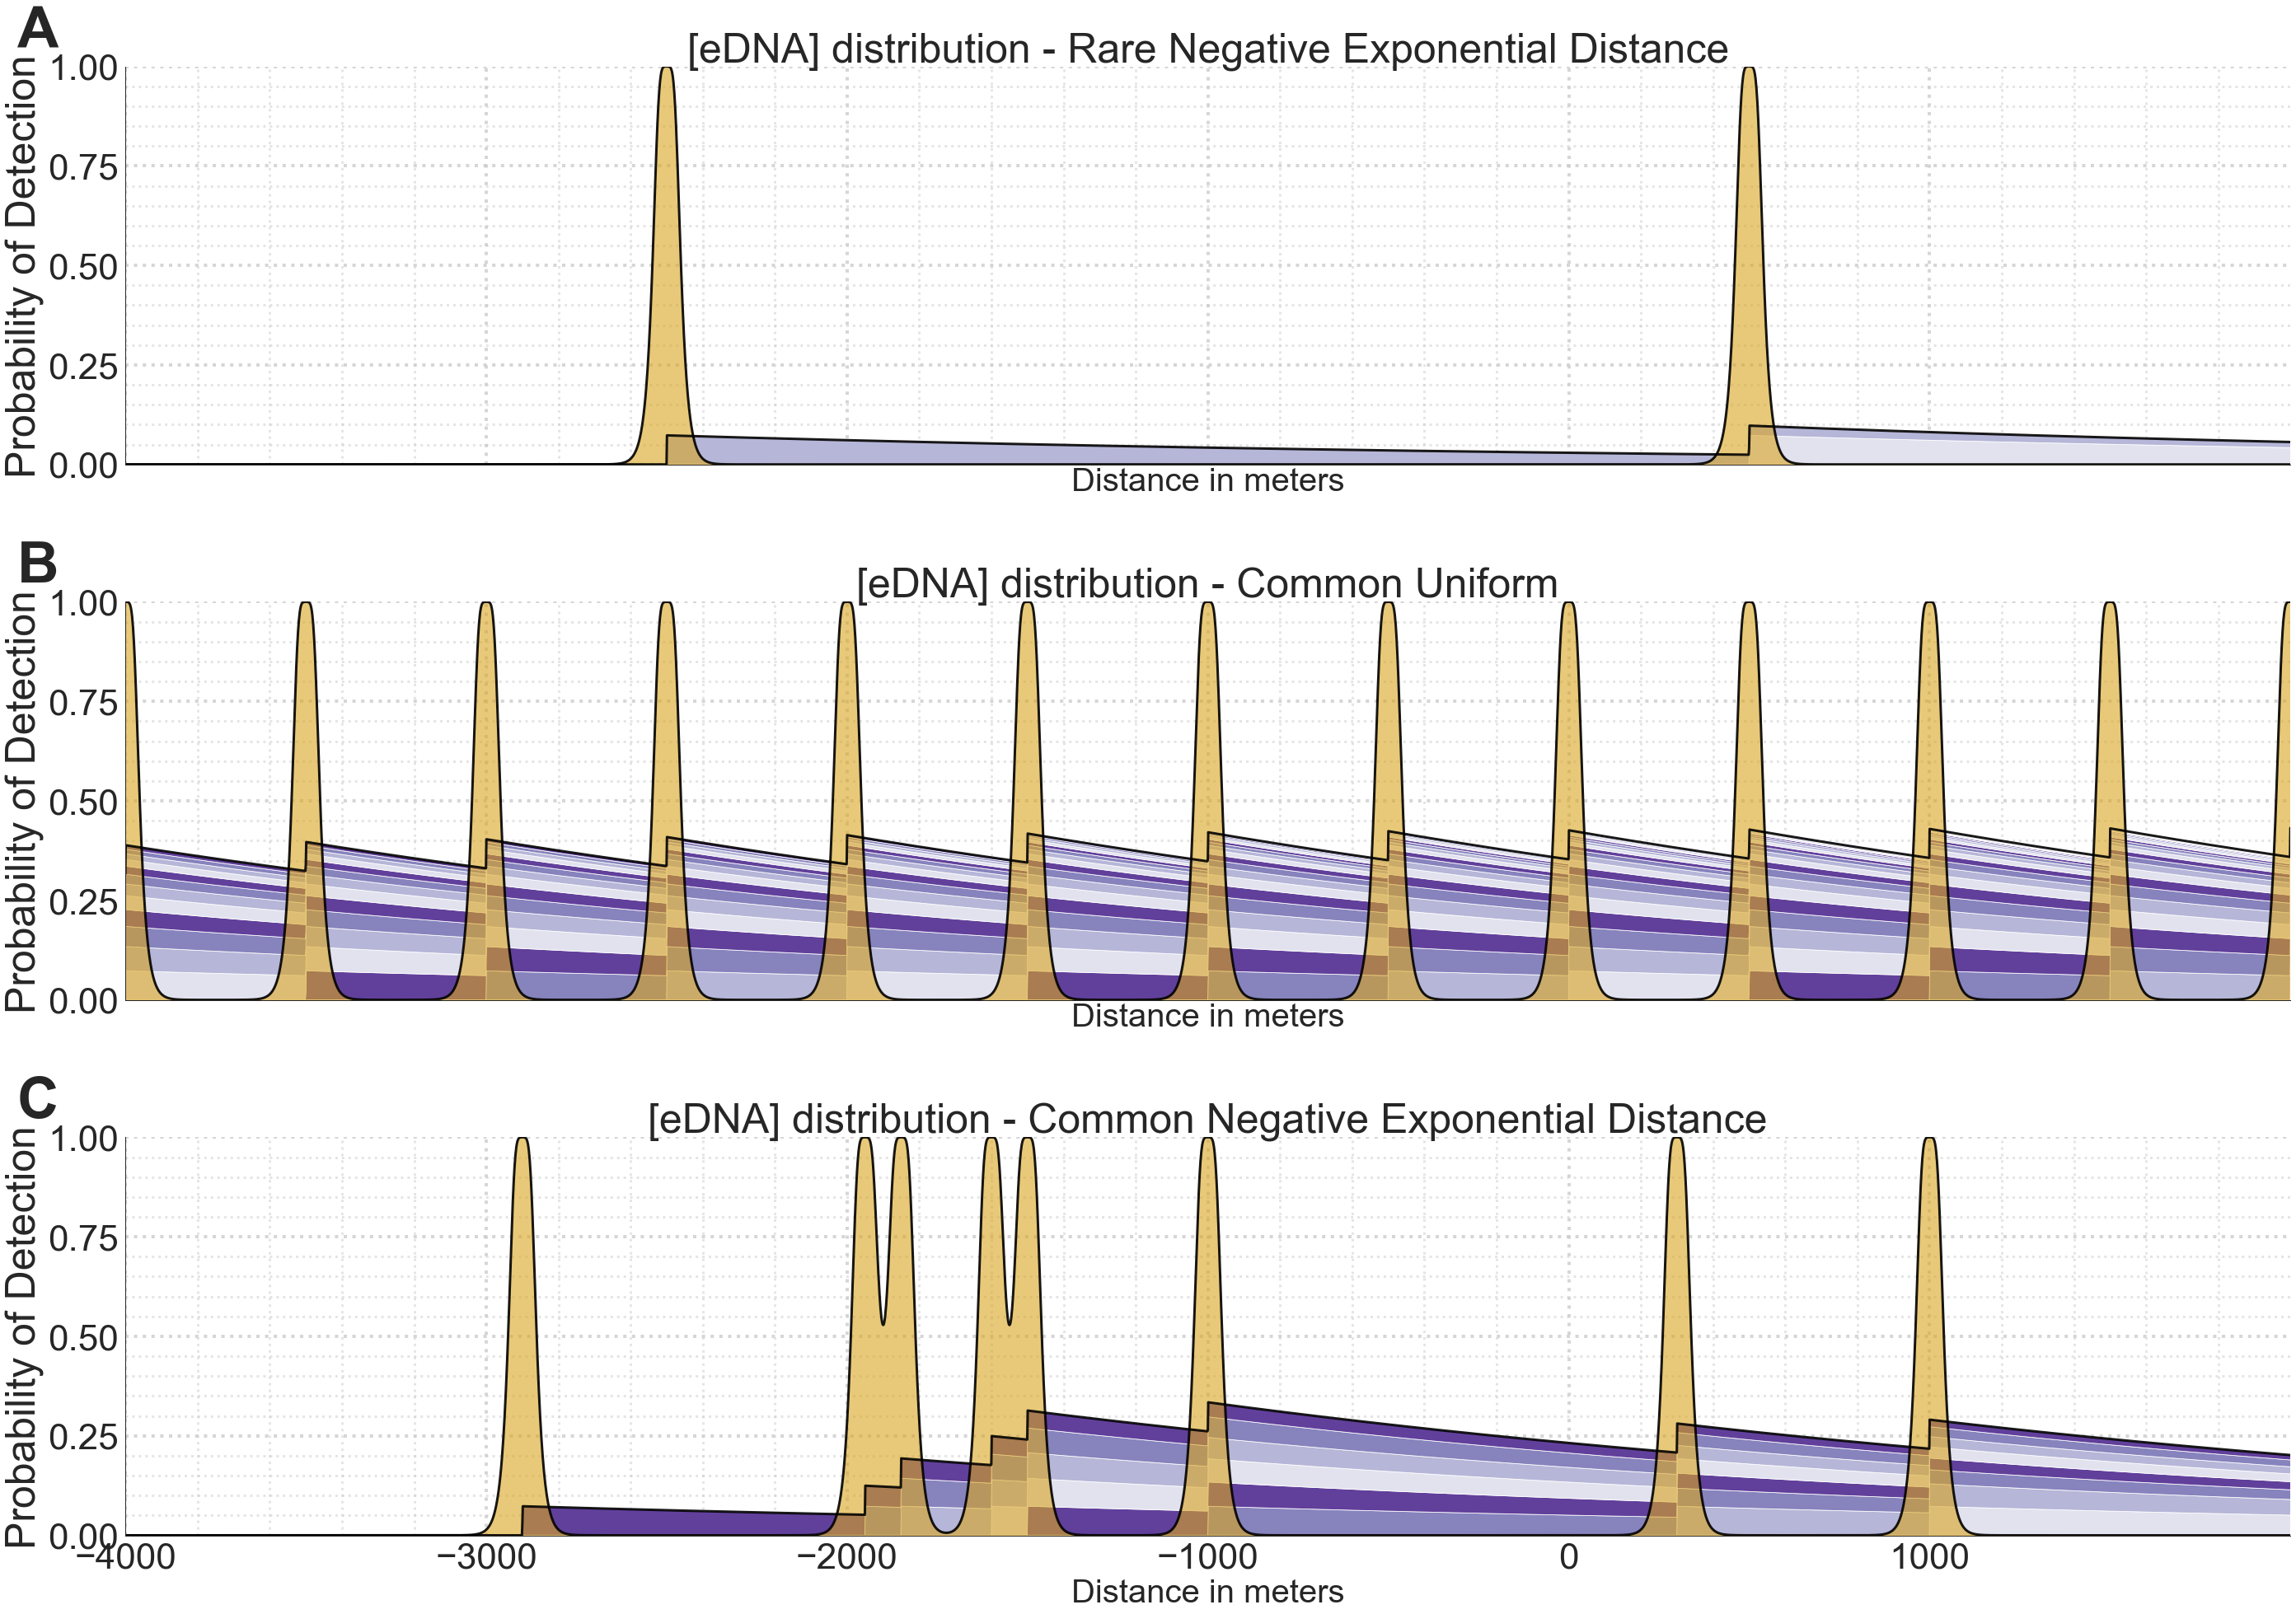

0.10407678060670733 0.20432099218035532


In [27]:
river = River()
river.init_fish(**fish_params)
river.init_river_params(**river_params)
river.init_sampling_strategy(**sampling_params)
river.error = 1e-1



fig, axs = plt.subplots(3, 1, figsize=(40,28.5), sharey=True, sharex = True)

for num in range(len(axs)):
    minor_ticksy = np.arange(0,1.001, .05)
    major_ticksy = np.arange(0,1.001, .25)
    minor_ticksx = np.arange(-4000,2000, 200)
    major_ticksx = np.arange(-4000,2000, 1000)
    axs[num].grid(linestyle = ':', linewidth=2)
    axs[num].set_xticks(major_ticksx)
    axs[num].set_xticks(minor_ticksx, minor=True)
    axs[num].set_yticks(major_ticksy)
    axs[num].set_yticks(minor_ticksy, minor=True)
    axs[num].grid(which='minor', alpha=0.5,linestyle = ':', linewidth=3)
    axs[num].grid(which='major', alpha=0.8,linestyle = '-', linewidth=5)


for num, fishcon in enumerate([ np.array([-250, 50])+200,np.array(range(-800, 800, 50)) +200,np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200]):
    n = 9
    ranges = np.linspace(-6000,6000,10000)
    fishes = fishcon*10

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-2400 + x,2400 + x,10000) for x in range(-5000, 5010, 50)]

    river.V = 0

    discrete1 = river.CtoP(sum([np.array([river.CeDNA_1_Source(x) for x in rg])  for rg in fish_loc]))
    axs[num].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') 

    river.V = .1


    discrete_list = [river.CtoP(np.array([river.CeDNA_1_Source(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') # + river.BV*river.T/2


    axs[num].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Purples", 4)) # + river.BV*river.T/2



    sns.despine()
    axs[num].set_ylim([0,1])
    #axs[num].set_xlim((-400,200))
    axs[num].set_xlim((-4000,2000))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'

    if num == 1:case = '[eDNA] distribution - Common Uniform'
    if num == 0:case = '[eDNA] distribution - Rare Negative Exponential Distance'
    if num == 2:case = '[eDNA] distribution - Common Negative Exponential Distance'
    if num == 3:case = 'x.HA.SI'
    axs[num].set_title(case,fontsize = 50)
    axs[num].set_xlabel('Distance in meters',fontsize = 40)
    axs[num].set_ylabel('Probability of Detection',fontsize = 50)
    axs[num].text(-0.05, 1.05, string.ascii_uppercase[num], transform=axs[num].transAxes, size=70, weight='bold') #

    #plt.title('')

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    axs[num].fill_between(ranges, discrete1 , 0, 
                     color = 'goldenrod', alpha = .6, label = 'Discrete sampling') 
    axs[num].grid(linestyle = ':', linewidth = 4)



plt.tight_layout()
river.print_params()
plt.show()
print(np.std(discrete), np.std(discrete1))



# Make Figure 5

B=1.0 dist=5 V=0.1 u=30937.5 λ=3.658333333333334e-05 D=0.01 H=10.0 pf=0.0016666666666666668 BV=0.8333333333333334 T=600


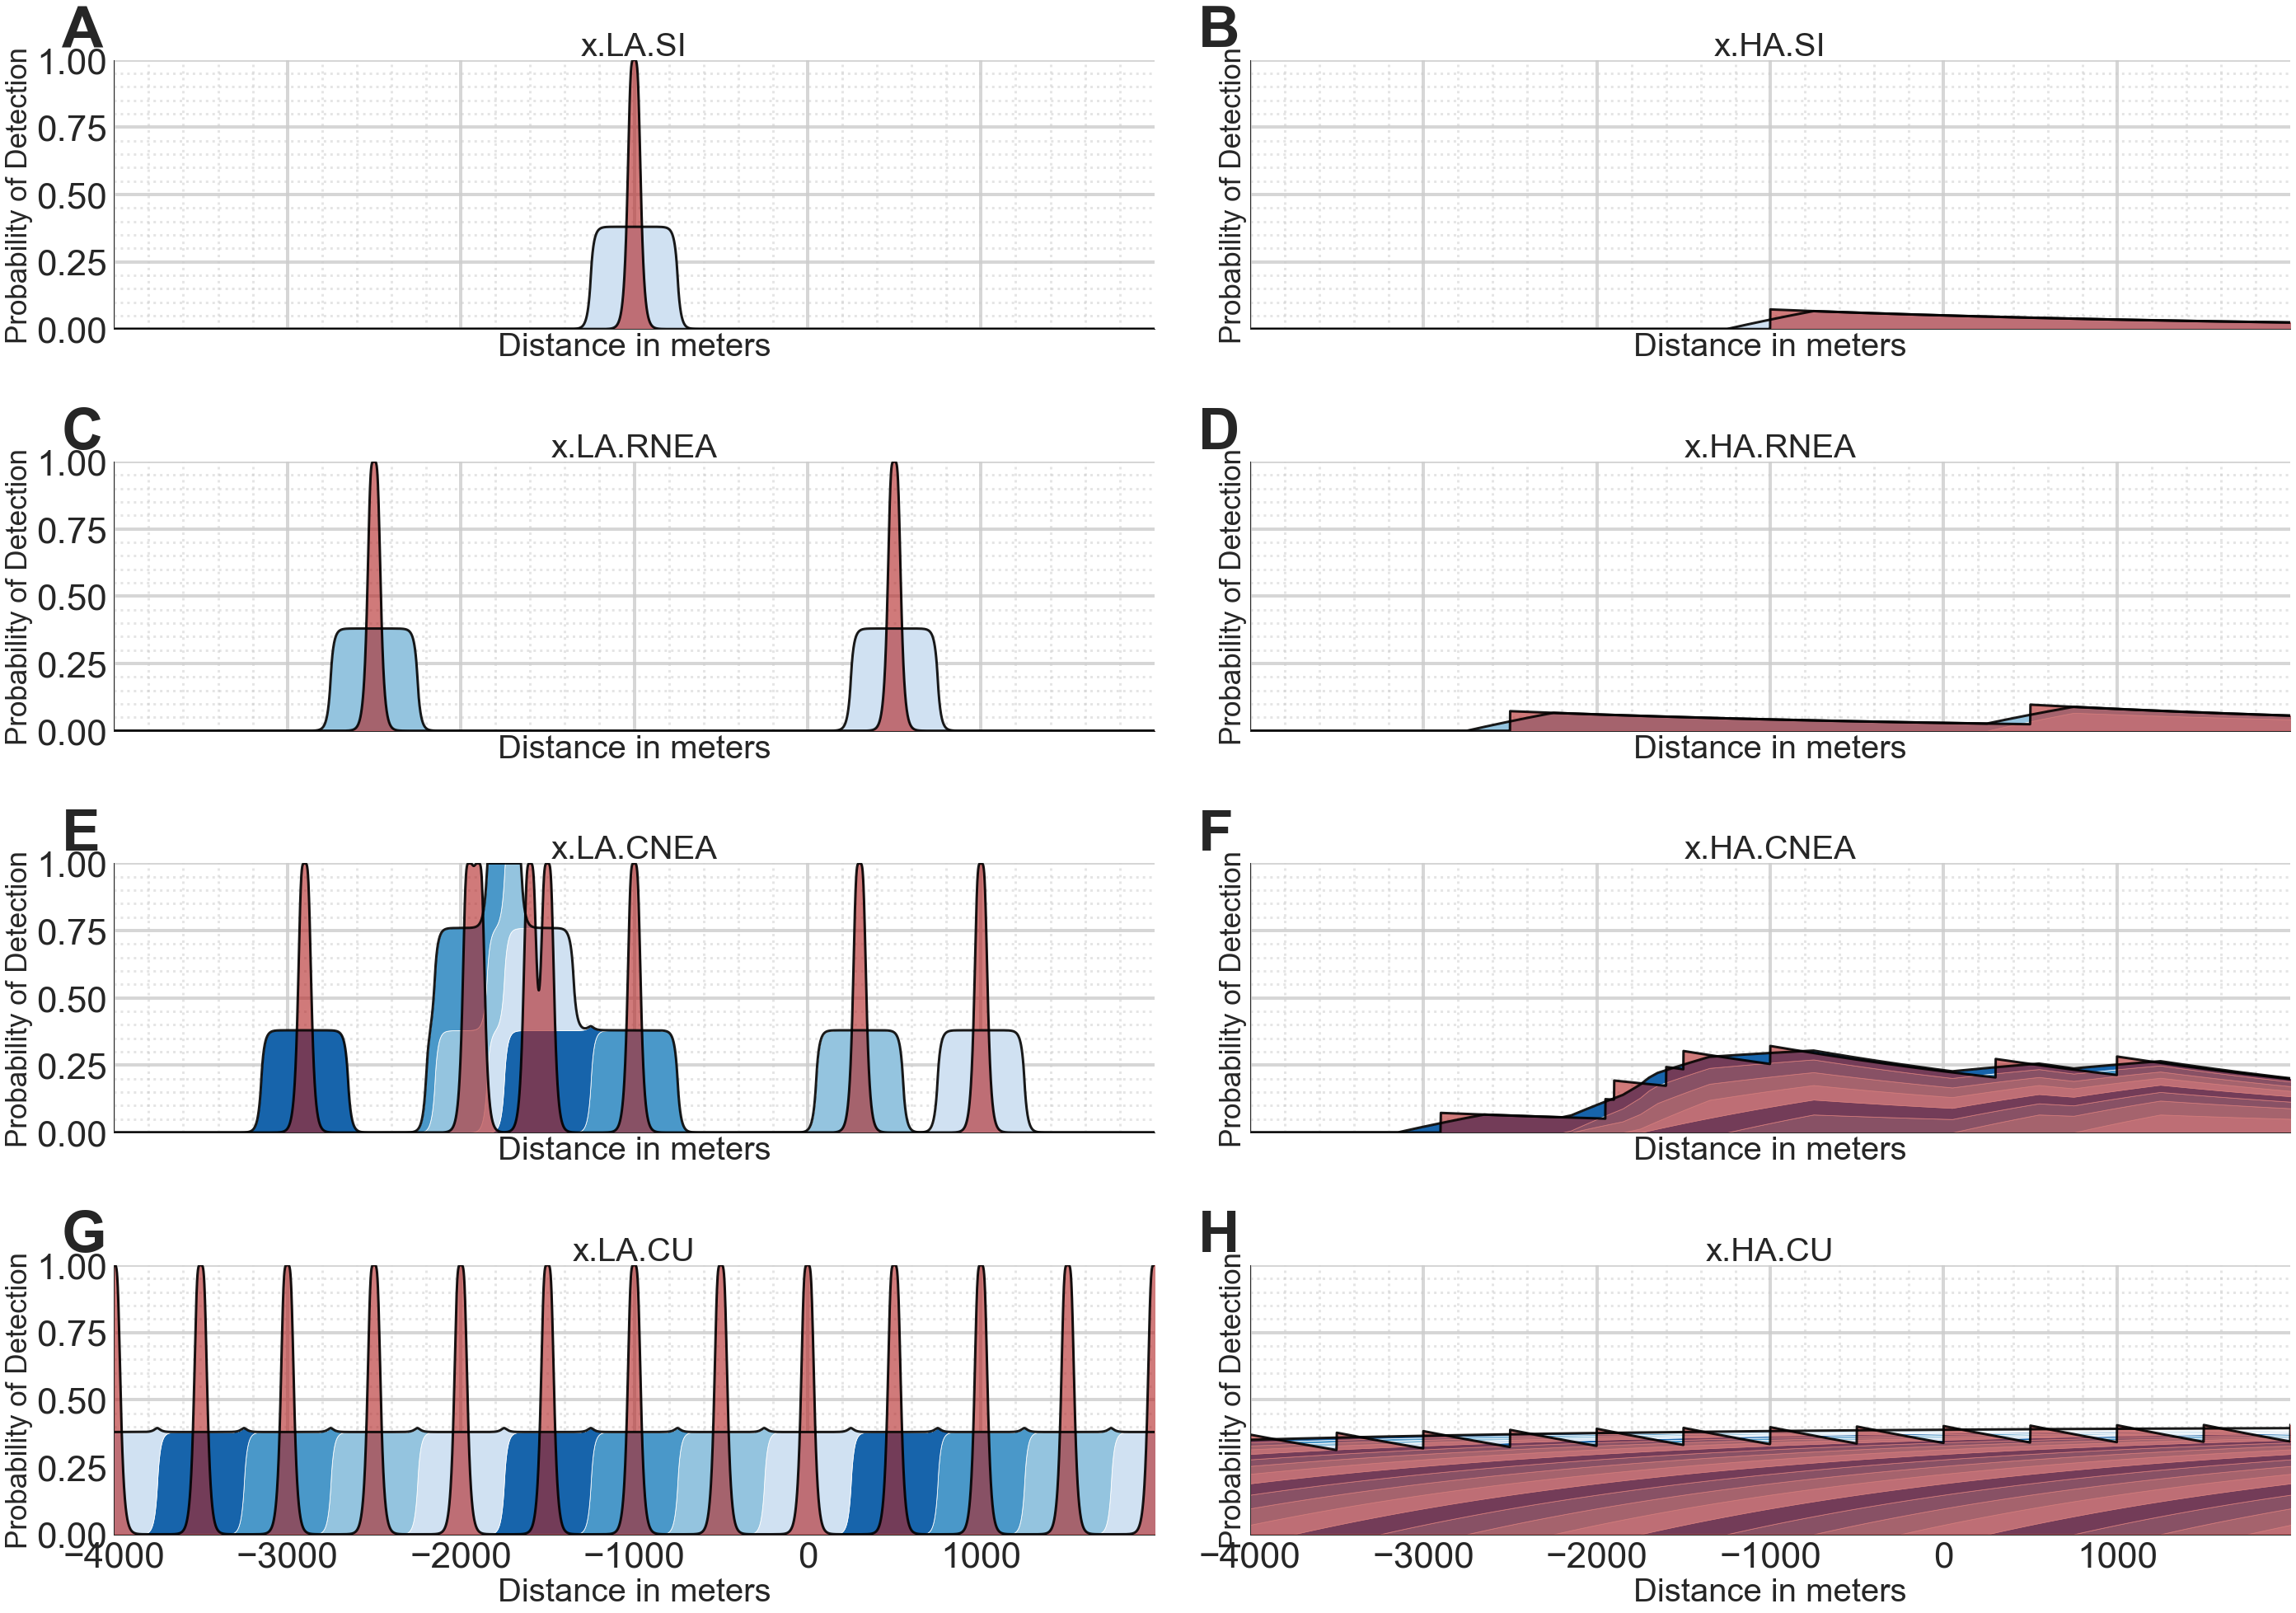

0.023292053681169014 0.028280335188865302


In [38]:
river = River()
river.init_fish(**fish_params)
river.init_river_params(**river_params)
river.init_sampling_strategy(**sampling_params)
river.error = 1e-1

fig, axs = plt.subplots(4, 2, figsize=(40,28.5), sharey=True, sharex = True)

for i,j in list(product([0,1,2,3], [0,1])):
    minor_ticksy = np.arange(0,1.001, .05)
    major_ticksy = np.arange(0,1.001, .25)
    minor_ticksx = np.arange(-4000,2000, 200)
    major_ticksx = np.arange(-4000,2000, 1000)
    axs[i,j].set_xticks(major_ticksx)
    axs[i,j].set_xticks(minor_ticksx, minor=True)
    axs[i,j].set_yticks(major_ticksy)
    axs[i,j].set_yticks(minor_ticksy, minor=True)
    axs[i,j].grid(which='minor', alpha=0.5,linestyle = ':', linewidth=3)
    axs[i,j].grid(which='major', alpha=0.8,linestyle = '-', linewidth=4)

def x2xy(x):
    L = x.max() - x.min()
    R = L/(2*np.pi)
    rg = x + x.min()
    q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
    return (np.array(q),r)

for num, fishcon in enumerate([np.array([100]), np.array([-250, 50])+200, np.array([-300, -230, -100, -50,-40, -10,-5,90]) +200, np.array(range(-800, 800, 50)) +200 ]):
    n = 9
    ranges = np.linspace(-6000,6000,10000)
    fishes = fishcon*10

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-4800 + x,4800 + x,10000) for x in range(-50000, 10010, 50)]
    river.V = 0
    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') #+ river.BV*river.T/2

    river.BV = 500/river.T

    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = [1 if x> 1 else x for x in sum(discrete_list)]
    axs[num, 0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') 
    axs[num, 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) 
    sns.despine()
    axs[num, 0].set_ylim([0,1])
    axs[num, 0].set_xlim((-4000, 2000))


    if num == 0:case = 'x.LA.SI'
    if num == 1:case = 'x.LA.RNEA'
    if num == 2:case = 'x.LA.CNEA'
    if num == 3:case = 'x.LA.CU'
    axs[num, 0].set_xlabel('Distance in meters',fontsize = 40)
    axs[num, 0].set_title(case,fontsize = 40)
    axs[num, 0].set_ylabel('Probability of Detection',fontsize = 35)
    axs[num, 0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .6, label = 'Discrete sampling') 
    axs[num, 0].text(-0.05, 1.05, string.ascii_uppercase[num*2], transform=axs[num, 0].transAxes, size=70, weight='bold')
    
    river.V = 0.1
    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 1].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') #+ river.BV*river.T/2

    river.BV = 500/river.T

    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = [1 if x> 1 else x for x in sum(discrete_list)]
    axs[num, 1].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') # + river.BV*river.T/2
    axs[num, 1].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2
    sns.despine()

    if num == 0:case = 'x.HA.SI'
    if num == 1:case = 'x.HA.RNEA'
    if num == 2:case = 'x.HA.CNEA'
    if num == 3:case = 'x.HA.CU'
    axs[num, 1].set_xlabel('Distance in meters',fontsize = 40)
    axs[num, 1].set_title(case,fontsize = 40)
    axs[num, 1].set_ylabel('Probability of Detection',fontsize = 35)
    axs[num, 1].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .6, label = 'Discrete sampling') 
    axs[num, 1].text(-0.05, 1.05, string.ascii_uppercase[num*2+1], transform=axs[num, 1].transAxes, size=70, weight='bold')

    

plt.tight_layout()
river.print_params()
plt.show()
print(np.std(discrete), np.std(discrete1))

# Make Figure 8

B=1.0 dist=5 V=0.1 u=30937.5 λ=3.658333333333334e-05 D=0.01 H=10.0 pf=0.0016666666666666668 BV=0.8333333333333334 T=600


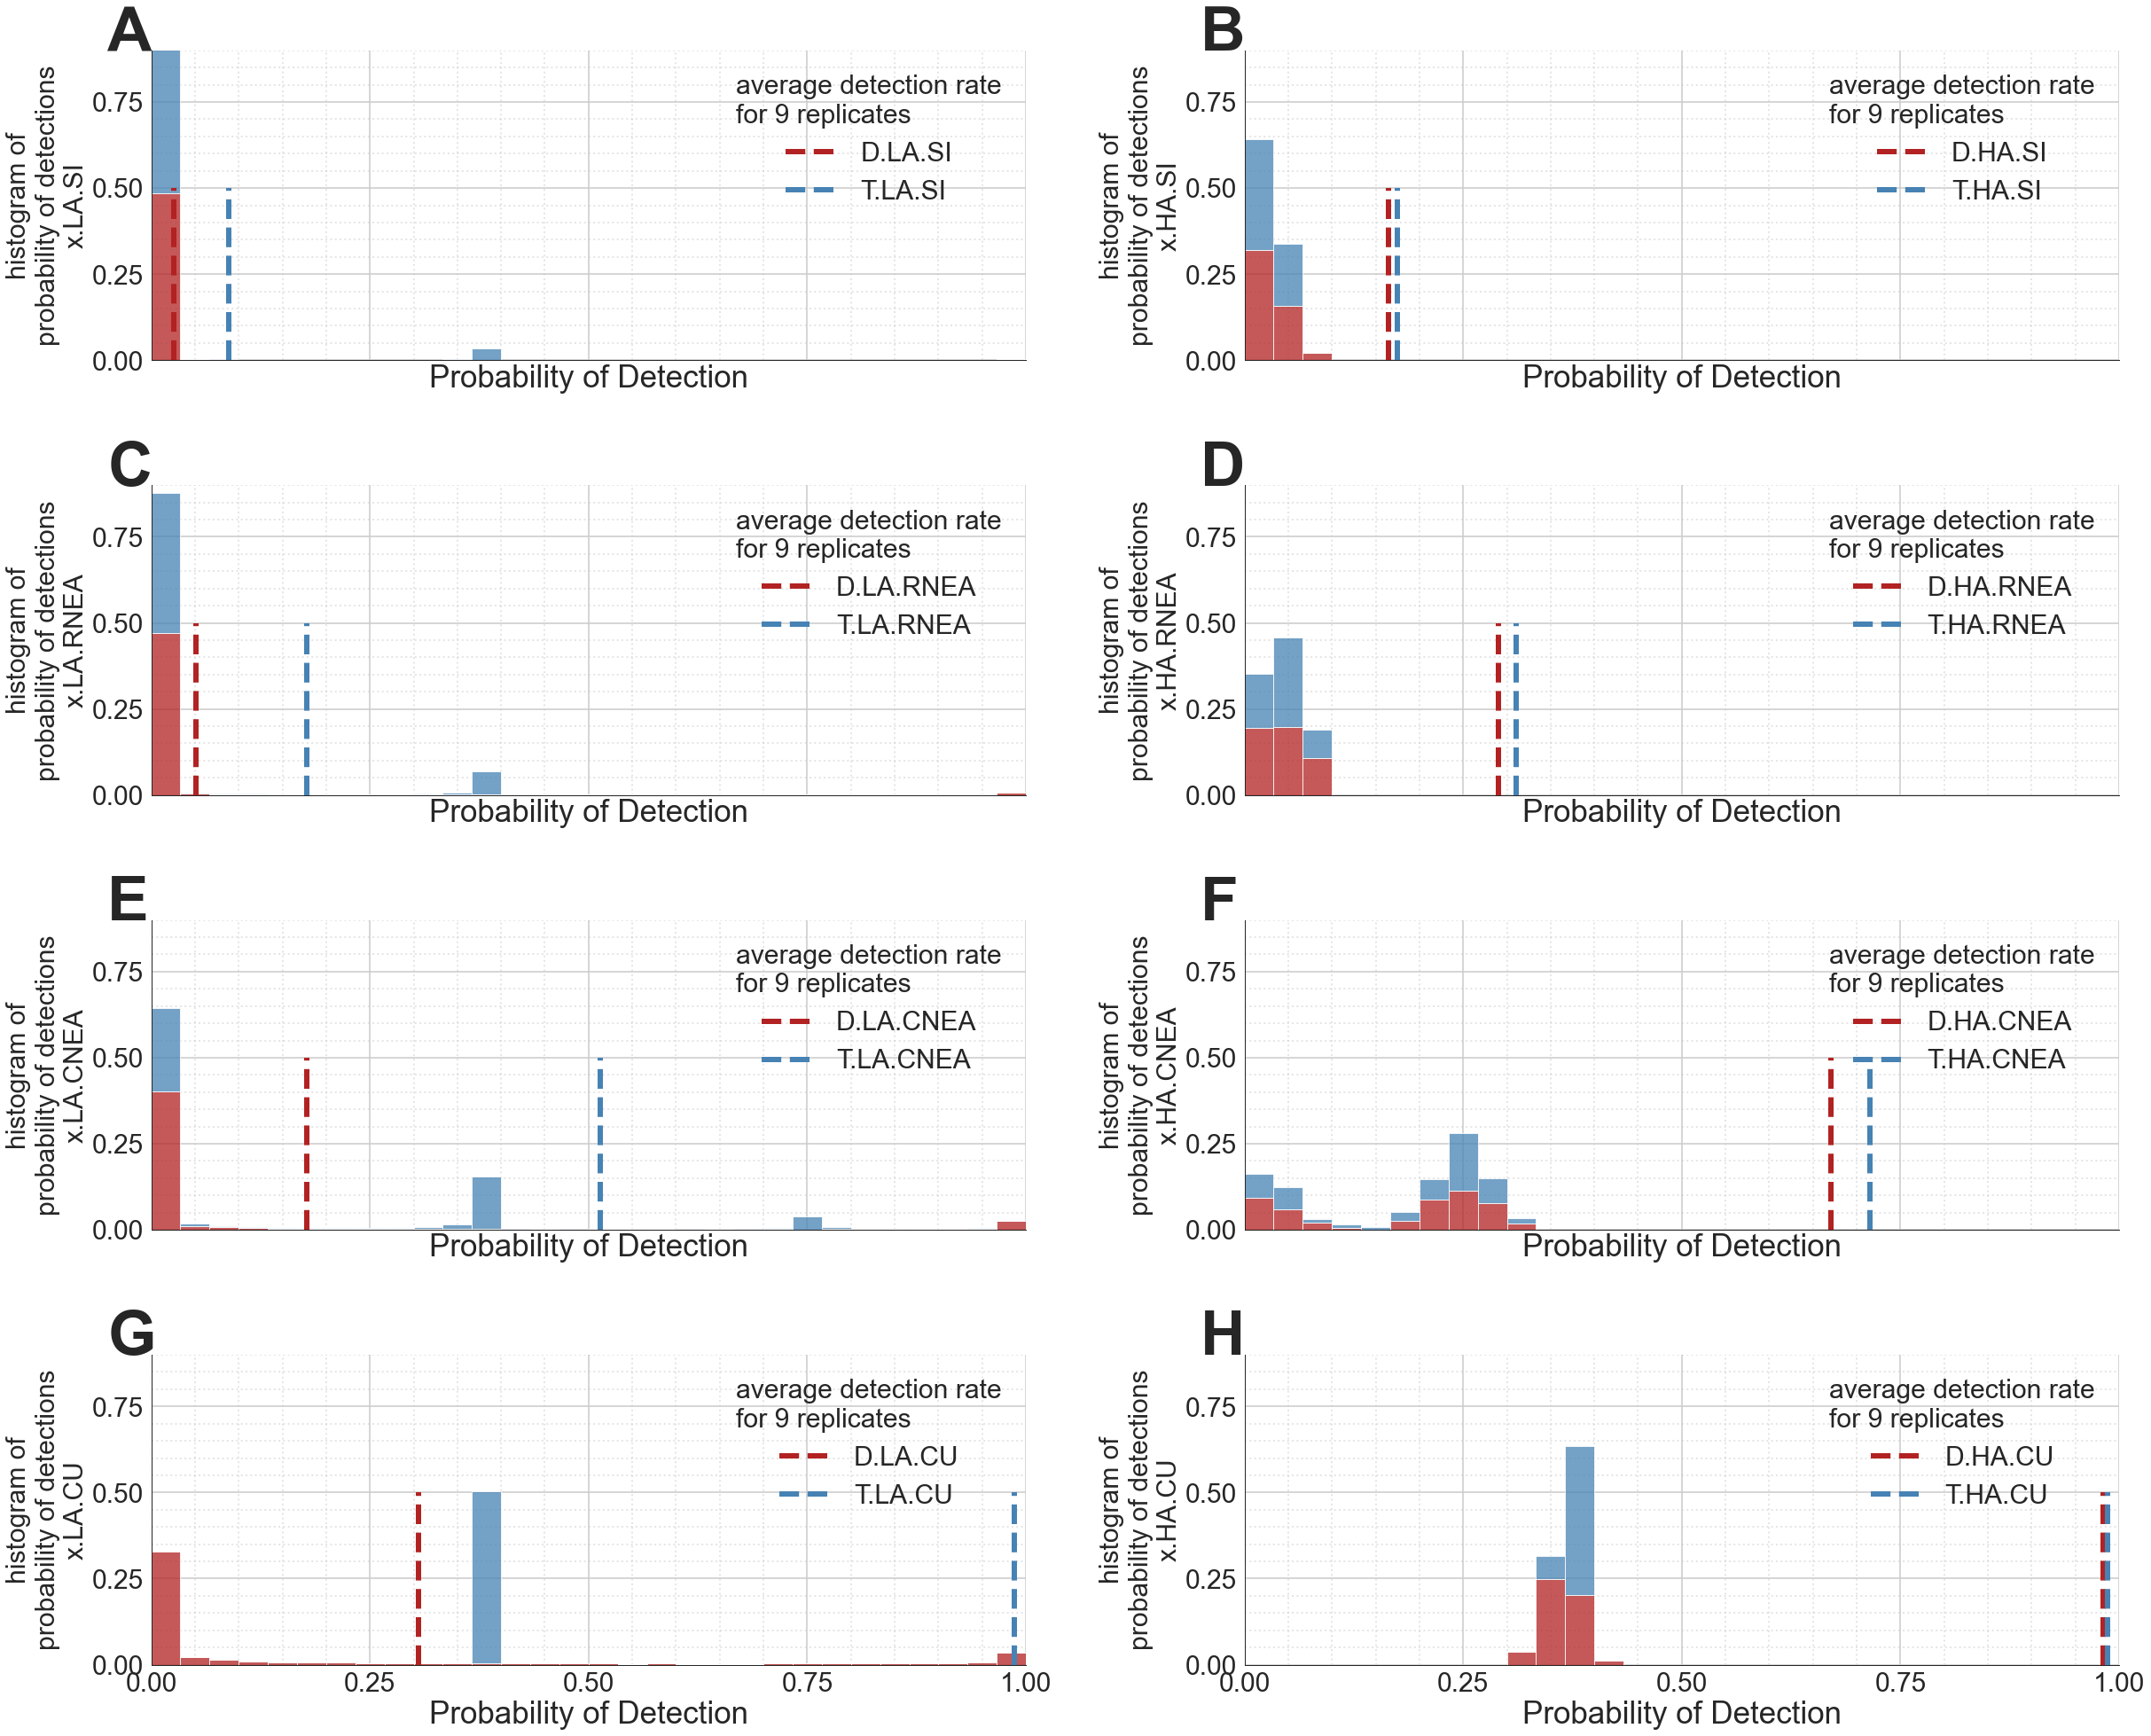

0.023292064199418348 0.028280342198343626


In [34]:
river = River()
river.init_fish(**fish_params)
river.init_river_params(**river_params)
river.init_sampling_strategy(**sampling_params)
river.error = 1e-1
sns.set(rc={'figure.figsize':(2*11.7,2*8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":100},style="white", context='paper',font_scale=5)



fig, axs = plt.subplots(4, 2, figsize=(35,28.5), sharex = True)

for i,j in list(product([0,1,2,3], [0,1])):
    minor_ticksy = np.arange(0,.91, .05)
    major_ticksy = np.arange(0,.91, .25)
    minor_ticksx = np.arange(0,1.01, .05)
    major_ticksx = np.arange(0,1.01, .25)
    axs[i,j].grid(linestyle = ':', linewidth=2)
    axs[i,j].set_xticks(major_ticksx)
    axs[i,j].set_xticks(minor_ticksx, minor=True)
    axs[i,j].set_yticks(major_ticksy)
    axs[i,j].set_yticks(minor_ticksy, minor=True)
    axs[i,j].set_xlabel('Probability of Detection',fontsize = 35)
    axs[i,j].grid(which='minor', alpha=0.5,linestyle = ':', linewidth=2)
    axs[i,j].grid(which='major', alpha=0.8,linestyle = '-', linewidth=2)


for num, fishcon in enumerate([np.array([100]), np.array([-250, 50])+200, np.array([-300, -230, -100, -50,-40, -10,-5,90]) +200, np.array(range(-800, 800, 50)) +200 ]):
    n = 9
    ranges = np.linspace(-6000,6000,10000)
    fishes = fishcon*10#fish_locations(45) #range(-1000, 1000, 50)#
    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-2400 + x,2400 + x,10000) for x in range(-10000, 10010, 50)]
    river.V = 0
    river.BV = 1e-5
    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    river.BV = 500/river.T

    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]

    if num == 0:case = 'x.LA.SI'
    if num == 1:case = 'x.LA.RNEA'
    if num == 2:case = 'x.LA.CNEA'
    if num == 3:case = 'x.LA.CU'

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    #plt.legend()
    plt.subplot(4, 2, num*2 + 1)
    #plt.ylim([0,max(discrete1)*1.1])
    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])
    sns.histplot( hue = 'method', x = 'Probability of Detection',  data = lg.query(' -4000 < position < 2000 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 30, binrange = [0,1])
    sns.despine()
    plt.vlines(x = (1- (1-lg.query(' -4000 < position < 2000 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.5,color = 'firebrick',linewidth = 6, linestyle = 'dashed', label = "D"+case[case.find('.'):])
    plt.vlines(x = (1-(1- lg.query(' -4000 < position < 2000 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.5,color = 'steelblue', linewidth = 6,linestyle = 'dashed', label = "T"+case[case.find('.'):] )
    plt.ylabel('histogram of\nprobability of detections\n'+ case, fontsize=30 )
    plt.xlim([0,1])
    plt.ylim([0,.9])
    plt.xlabel('Probability of Detection',fontsize = 35)
    plt.legend(loc='best', title="average detection rate\nfor {0:0d} replicates".format(n), fontsize=30, title_fontsize =30 )
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.text(-0.05, .9, string.ascii_uppercase[num*2],  size=70, weight='bold')

    
    river.V = 0.1
    river.BV = 1e-5
    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    river.BV = 500/river.T


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)

    if num == 0:case = 'x.HA.SI'
    if num == 1:case = 'x.HA.RNEA'
    if num == 2:case = 'x.HA.CNEA'
    if num == 3:case = 'x.HA.CU'

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    #plt.legend()
    plt.subplot(4, 2, num*2 + 2)
    plt.xlim([0,max(discrete1)*1.1])
    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])
    sns.histplot( hue = 'method', x = 'Probability of Detection',  data = lg.query(' -4000 < position < 2000 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 30, binrange = [0,1])
    sns.despine()
    plt.vlines(x = (1- (1-lg.query(' -4000 < position < 2000 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.5,color = 'firebrick',linewidth = 6, linestyle = 'dashed', label = "D"+case[case.find('.'):])
    plt.vlines(x = (1-(1- lg.query(' -4000 < position < 2000 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.5,color = 'steelblue', linewidth = 6,linestyle = 'dashed', label = "T"+case[case.find('.'):] )
    plt.ylabel('histogram of\nprobability of detections\n'+ case, fontsize=30 )
    plt.xlim([0,1])
    plt.xlabel('Probability of Detection',fontsize = 35)
    plt.legend(loc='best', title="average detection rate\nfor {0:0d} replicates".format(n), fontsize=30, title_fontsize =30 )
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.ylim([0,.9])
    plt.text(-0.05, .9, string.ascii_uppercase[num*2+1],  size=70, weight='bold')
    



plt.tight_layout()
river.print_params()
plt.show()
print(np.std(discrete), np.std(discrete1))


In [33]:
@interact_manual(
         maxV = widgets.BoundedFloatText(value=.9, min=0, max=10, step=1,      layout = layout, style = style),
         maxTransect = widgets.BoundedFloatText(value=1100, min=1e-5, max=10000, step=100, layout = layout, style = style),
)
def MakeFig6(maxV,maxTransect):
    river = River()
    river.init_fish(**fish_params)
    river.init_river_params(**river_params)
    river.init_sampling_strategy(**sampling_params)
    river.error = 1e-1
    river.PofCaptureNet = 0.01

    sma = []
    certaity =  1- 0.05**(1/9)
    bv_space = np.linspace(1e-10, maxTransect, 100)/river.T 
    rivV_space =  np.linspace(0, maxV,  100) 
    for bv,V in product(bv_space, rivV_space):
        try:
            river.V = V
            river.BV = bv
            down, up = river.Find_detection_range(certaity)
            sma += [[V, bv*river.T, up, down]]
        except: sma += [[V, bv*river.T,0,0]]
    lg =pd.DataFrame(sma, columns = ['Advection', 'Transect length', 'sup', 'inf'])
    lg['group'] = lg.apply(lambda row: 'Adv: {:.2f}; Boat_V: {:.2f}'.format(row['Advection'], row['Transect length']), axis = 1)
    lg['space'] = lg.apply(lambda row: list(range(int(row['inf']), int(row['sup']))), axis = 1)
    lg['length'] = lg.sup -lg.inf
    lg = lg.sort_values(['Advection', 'Transect length'], ascending = False)

    sns.set(rc={'figure.figsize':(2*11.7,2*8.),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)

    a = sns.heatmap(gaussian_filter(lg[['Transect length', 'Advection', 'length']].pivot('Transect length', 'Advection'), 0), cmap = 'Spectral',  
                xticklabels = [ "{:.4fn}".format(y) if x  % 3 ==0 else '' for x, y in enumerate(rivV_space)],
                yticklabels = [ str(round(y)) if x  % 3 ==0 else '' for x, y in enumerate(bv_space*river.T)],
                cbar_kws={'label': 'ESD(m) for P(detection) > '+ f"{certaity:.4f}"}, 
                square = 1 )


    plt.xticks(fontsize = 20)
    a.invert_yaxis()
    plt.yticks(fontsize = 20)


    plt.ylabel("Transect length (m)",fontsize = 25)
    plt.xlabel("River Velocity (m/s)",fontsize = 25)
    plt.tight_layout()
    river.print_params()

interactive(children=(BoundedFloatText(value=0.9, description='maxV', layout=Layout(align_items='stretch', dis…